## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
%matplotlib inline
from skimage.feature import hog
from lesson_functions import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

## 1. Train a linear SVM classifier
### 1.1 Histogram of Oriented Gradient (HOG)

In [2]:
def show_hog(img, image_path = './output_images/test01.png', save_img = False):
    feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    fig, ax = plt.subplots(3, 3, figsize=(30,30))
    #fig.tight_layout()
    for i in range(3):
        ax[i][0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB));
        ax[i][0].set_title('Original Image', fontsize=20);
        ax[i][1].imshow(feature_image[:,:,i], cmap = 'gray');
        ax[i][1].set_title(str(i)+'-channel Image', fontsize=20);
        features, hog_img = get_hog_features(feature_image[:,:,i], orient, 
            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        ax[i][2].imshow(hog_img, cmap = 'gray');
        ax[i][2].set_title(str(i)+'-channel HOG Image', fontsize=20);
        for j in range(3):
            ax[i][j].set_xticks(())
            ax[i][j].set_yticks(())
    if save_img:
        plt.savefig(image_path)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


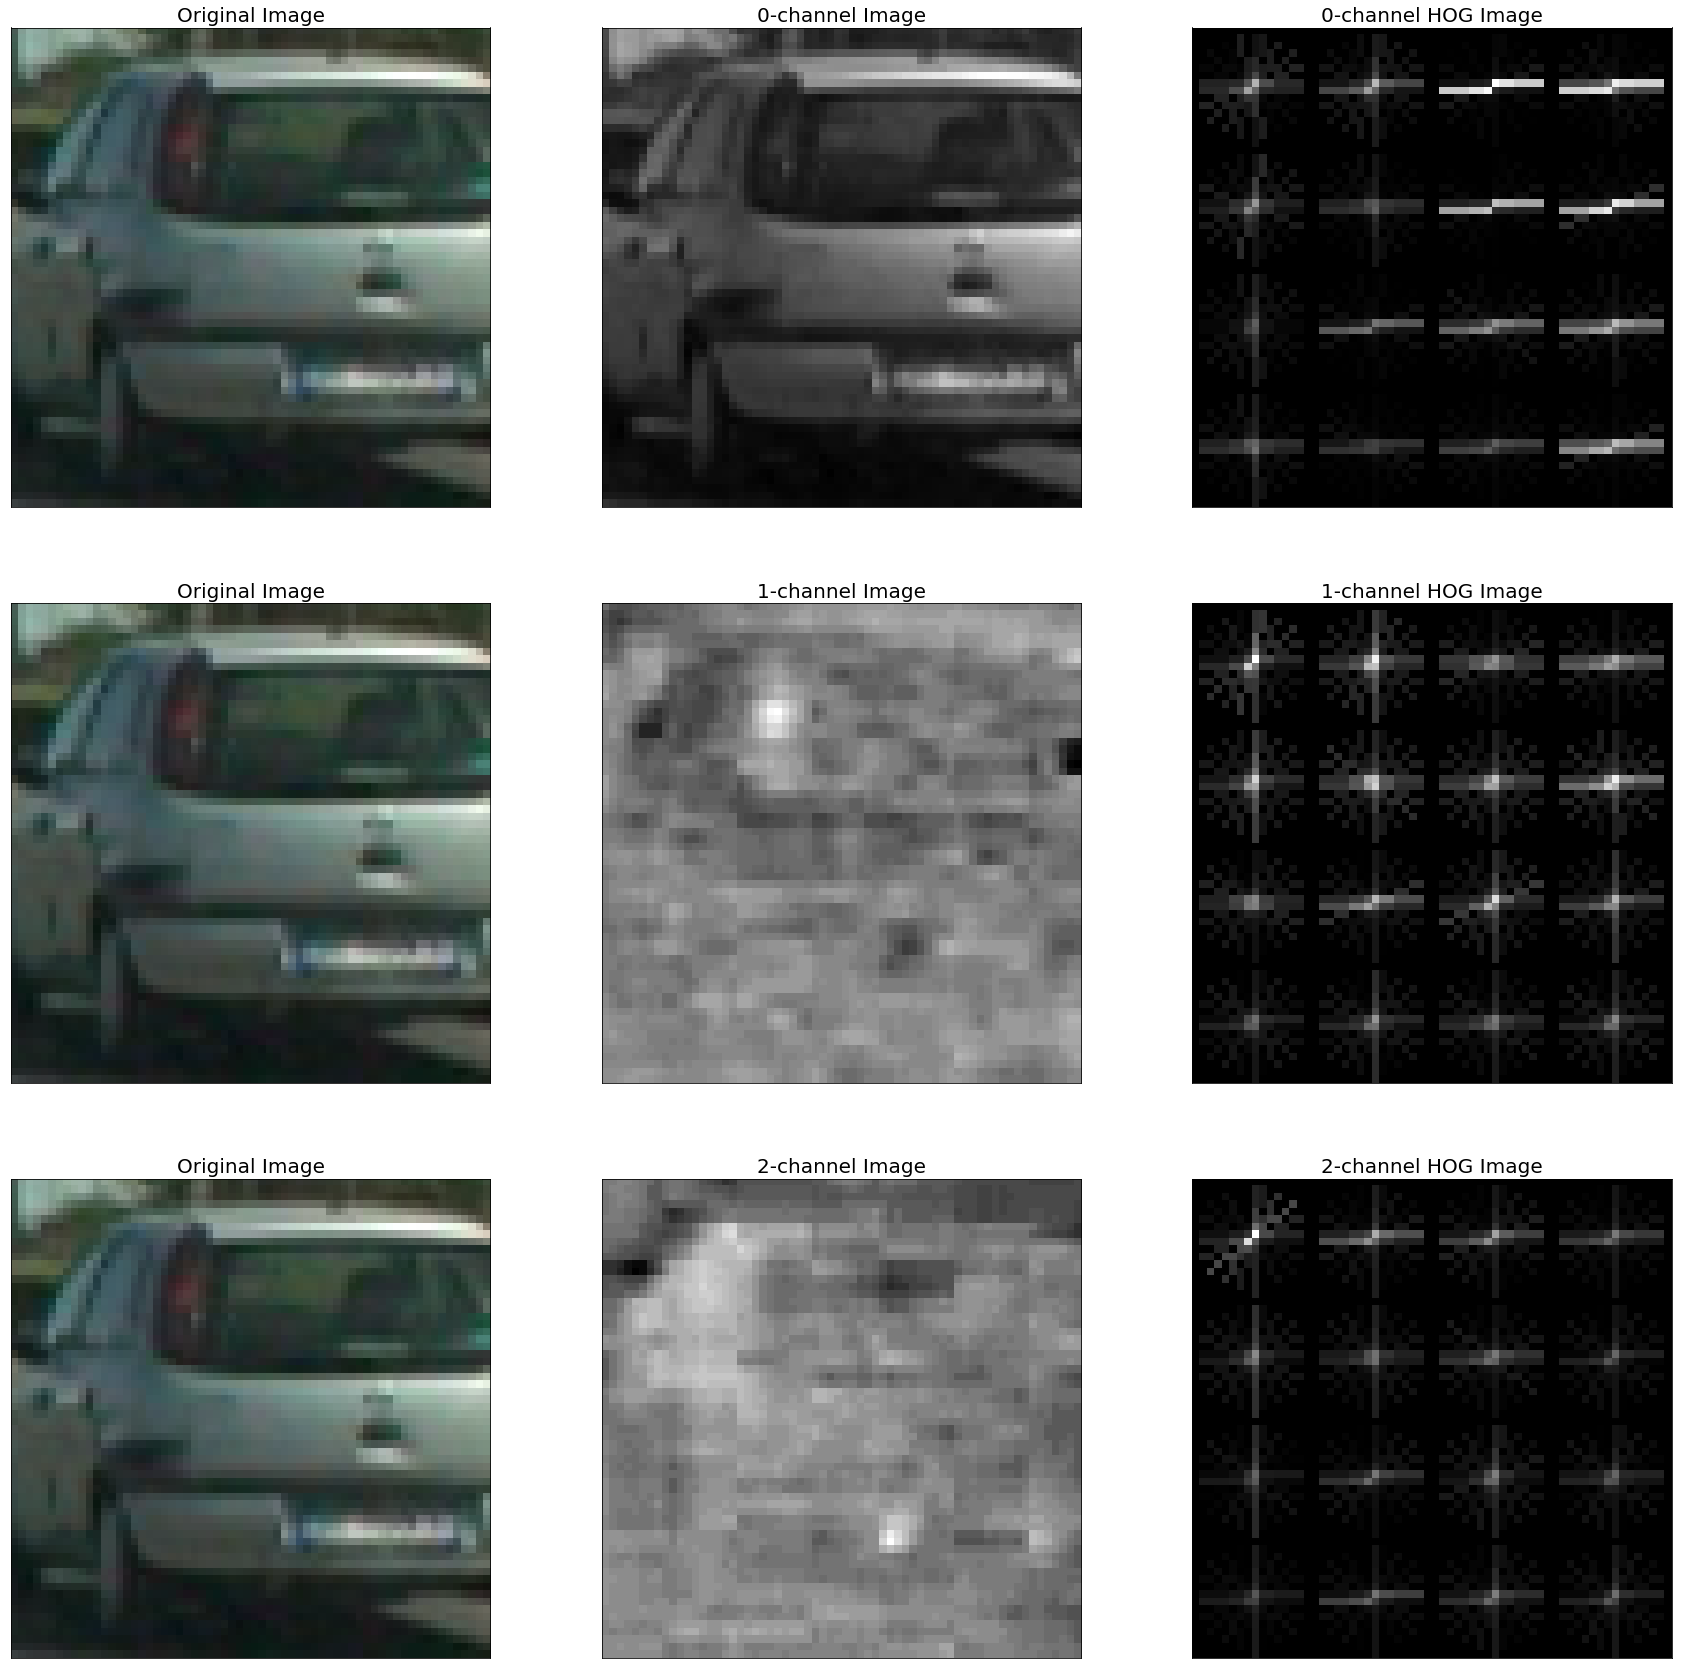

In [3]:
#show HOG image for a test image with vehicle
car_img = cv2.imread('./vehicles/GTI_Right/image0333.png')
image_path = './output_images/hog_GTI_Right_image0333.png'
show_hog(car_img, image_path = image_path, save_img = True)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


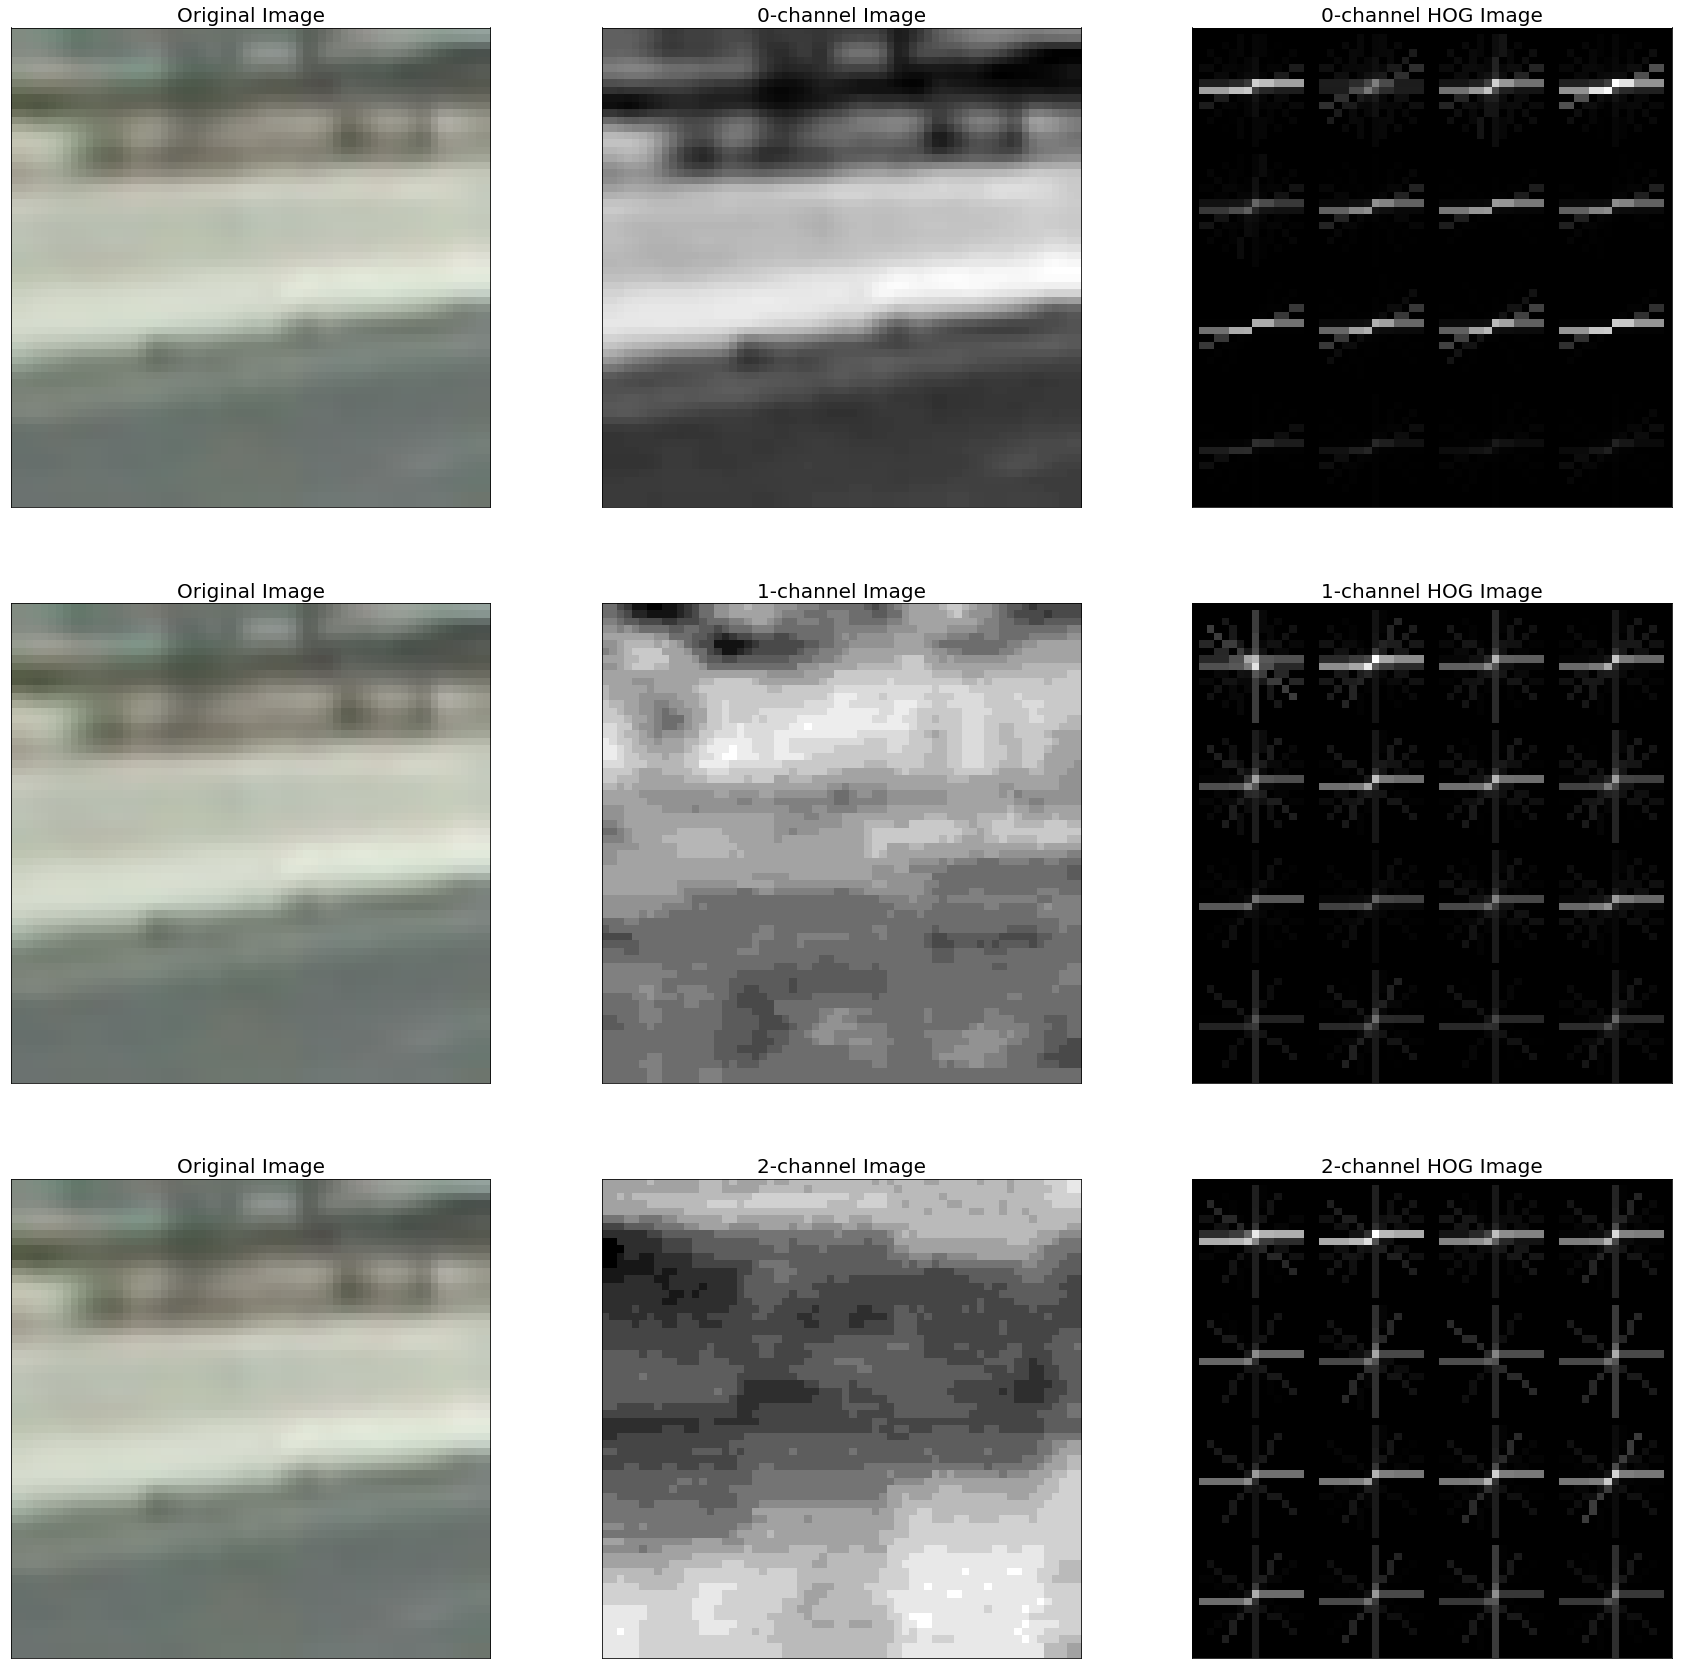

In [4]:
#show HOG image for a test image without vehicle
noncar_img = cv2.imread('./non-vehicles/GTI/image1007.png')
image_path = './output_images/hog_GTI_image1007.png'
show_hog(noncar_img, image_path = image_path, save_img = True)

### 1.2 Color Histograms

In [5]:
def show_colorhist(img, image_path = './output_images/test01.png', save_img = False):
    feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    hist_bins = 32
    hist0, hist1, hist2, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, vis = True)
    #print(bincen)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, hist0[0])
    plt.xlim(0, 256)
    plt.title('0-channel Histogram')
    plt.subplot(132)
    plt.bar(bincen, hist1[0])
    plt.xlim(0, 256)
    plt.title('1-channel Histogram')
    plt.subplot(133)
    plt.bar(bincen, hist2[0])
    plt.xlim(0, 256)
    plt.title('2-channel Histogram')
    fig.tight_layout()
    if save_img:
        plt.savefig(image_path)

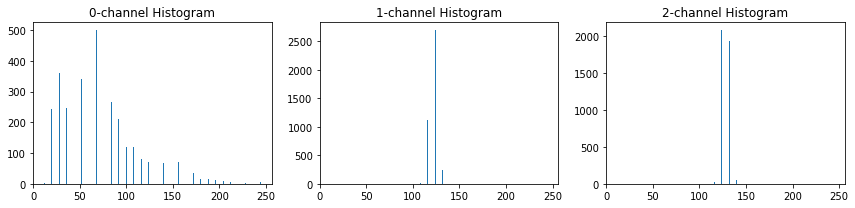

In [6]:
#show color histogram for a test image with vehicle
image_path = './output_images/colorhist_GTI_Right_image0333.png'
show_colorhist(car_img, image_path = image_path, save_img = True)

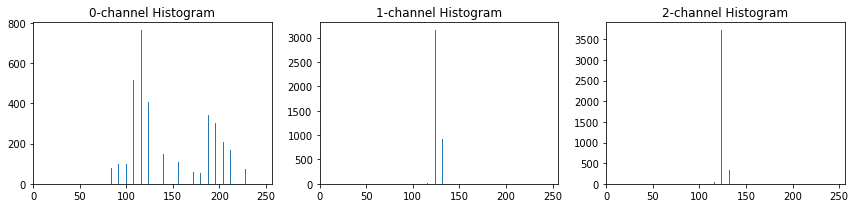

In [7]:
#show color histogram for a test image without vehicle
image_path = './output_images/colorhist_GTI_image1007.png'
show_colorhist(noncar_img, image_path = image_path, save_img = True)

### 1.3 Feature Normalization

In [8]:
# Make lists of vehicle/non-vehicle images
vehicles = glob.glob('./vehicles/*/*')
nonvehicles = glob.glob('./non-vehicles/*/*')

In [9]:
orient = 11
pix_per_cell = 16
cell_per_block = 2
hist_bins = 32

In [10]:
vehicles_feat = extract_features(vehicles, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=False, hist_feat=True, hog_feat=True)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [11]:
nonvehicles_feat = extract_features(nonvehicles, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL',
                        spatial_feat=False, hist_feat=True, hog_feat=True)

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [12]:
# Create an array stack of feature vectors
# The right format to sklearn StandardScaler: a numpy array where each row is a single feature vector
X = np.vstack((vehicles_feat, nonvehicles_feat)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [13]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(scaled_X[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1284


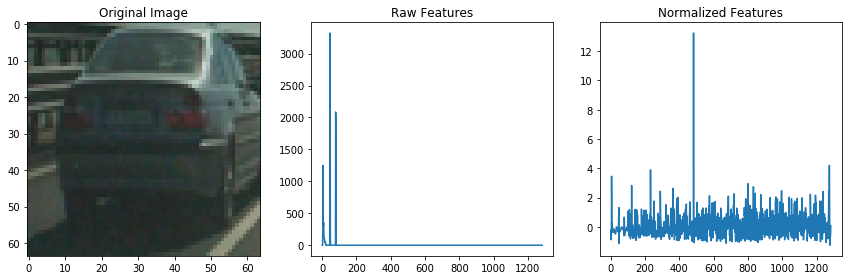

In [14]:
# randomly choose an image with vehicle
car_ind = np.random.randint(0, len(vehicles_feat))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(cv2.imread(vehicles[car_ind]), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig('./output_images/normalize_feats.png')

### 1.4 Preparation

In [15]:
# Define the labels vector
y = np.hstack((np.ones(len(vehicles_feat)), np.zeros(len(nonvehicles_feat))))

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### 1.5 Tune SVM parameters

In [17]:
%%time
parameters = {'C':[1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
             'loss': ['hinge','squared_hinge']} #'penalty':['l1','l2'], 
svc = LinearSVC()
models = GridSearchCV(estimator = svc, 
                      param_grid = parameters,
                      scoring = ['accuracy', 'f1'],
                      cv = 5,
                      n_jobs = -1,
                      verbose = 1,
                      refit = 'f1')

models.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.3s finished


CPU times: user 16.7 s, sys: 405 ms, total: 17.1 s
Wall time: 29.4 s


In [18]:
# best f1 score
print('Best f1 score = {:.4f}'.format(models.best_score_))
# best parameter C
print('Best parameters:',models.best_params_)

Best f1 score = 0.9936
Best parameters: {'loss': 'squared_hinge', 'C': 0.003}


In [19]:
svc_final = LinearSVC(C = models.best_params_['C'], loss = models.best_params_['loss'])
svc_final.fit(X_train, y_train)
y_pred = svc_final.predict(X_test)

In [20]:
print('Test set accuracy = {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('Test set F1 score = {:.4f}'.format(f1_score(y_test, y_pred)))

Test set accuracy = 0.9961
Test set F1 score = 0.9959
